## Starbucks customers offers dataset. The dataset can be downloaded from Kaggle using the following link 
https://www.kaggle.com/blacktile/starbucks-app-customer-reward-program-data?select=transcript.json

In [1]:
pwd

In [2]:
# !pip install lifetimes
# !pip install -U yellowbrick

In [3]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [5]:
from yellowbrick.cluster.elbow import kelbow_visualizer
from lifetimes.utils import summary_data_from_transaction_data

C:\Users\mayan\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


##  Exploratory data analysis

In [6]:
#Loading the datasets
portfolio = pd.read_json('C:/Users/mayan/Desktop/1TouchSolutions/Marketing/starbucks-customer-segmentation-master/data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('C:/Users/mayan/Desktop/1TouchSolutions/Marketing/starbucks-customer-segmentation-master/data/profile.json', orient='records', lines=True)
transcript=pd.read_json('C:/Users/mayan/Desktop/1TouchSolutions/Marketing/starbucks-customer-segmentation-master/data/transcript.json', orient='records', lines= True)


In [7]:
print(portfolio.shape)
portfolio.head()

(10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [8]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
print(transcript.shape)
transcript.head

(306534, 4)


<bound method NDFrame.head of                                   person           event  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received   
1       a03223e636434f42ac4c3df47e8bac43  offer received   
2       e2127556f4f64592b11af22de27a7932  offer received   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4       68617ca6246f4fbc85e91a2a49552598  offer received   
...                                  ...             ...   
306529  b3a1272bc9904337b331bf348c3e8c17     transaction   
306530  68213b08d99a4ae1b0dcb72aebd9aa35     transaction   
306531  a00058cf10334a308c68e7631c529907     transaction   
306532  76ddbd6576844afe811f1a3c0fbb5bec     transaction   
306533  c02b10e8752c4d8e9b73f918558531f7     transaction   

                                                   value  time  
0       {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1       {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2       {'offer id': '2906b810c7d4411798c6938adc9daaa5

In [10]:
# convert dates to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format= '%Y%m%d')
#fill missing values for gender
profile['gender']=profile['gender'].fillna('NA')

print('Unique genders:')
print(profile['gender'].unique())

print('Descriptive statistics for income and age')
print(profile.describe())


Unique genders:
['NA' 'F' 'M' 'O']
Descriptive statistics for income and age
                age         income
count  17000.000000   14825.000000
mean      62.531412   65404.991568
std       26.738580   21598.299410
min       18.000000   30000.000000
25%       45.000000   49000.000000
50%       58.000000   64000.000000
75%       73.000000   80000.000000
max      118.000000  120000.000000


In [11]:
# Imputing income
profile['income_na']=profile['income'].isna().astype(int)
profile['income']=profile['income'].fillna(profile['income'].mean())

In [12]:
print(profile.head())

  gender  age                                id became_member_on  \
0     NA  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12   
1      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15   
2     NA  118  38fe809add3b4fcf9315a9694bb96ff5       2018-07-12   
3      F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09   
4     NA  118  a03223e636434f42ac4c3df47e8bac43       2017-08-04   

          income  income_na  
0   65404.991568          1  
1  112000.000000          0  
2   65404.991568          1  
3  100000.000000          0  
4   65404.991568          1  


In [13]:
# One hot encoding
mlb = MultiLabelBinarizer()
channel_dummies = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_, index=portfolio.index)

# offer type dummies
offer_type_dummies = portfolio['offer_type'].str.get_dummies()

portfolio = pd.concat([portfolio, channel_dummies, offer_type_dummies], axis=1)

#portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)

portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [14]:
# gender type dummies
profile['year_joined'] = profile['became_member_on'].apply(lambda x: str(x.year))

gender_dummies = profile['gender'].str.get_dummies().add_prefix('gender_')
year_joined_dummies = profile['year_joined'].str.get_dummies().add_prefix('year_joined_')

profile = pd.concat([profile, gender_dummies, year_joined_dummies], axis=1)

#profile.drop(['gender'], axis=1, inplace=True)
profile.drop(['became_member_on'], axis=1, inplace=True)
profile.drop(['year_joined'], axis=1, inplace=True)

profile.head()

,gender,age,id,income,income_na,gender_F,gender_M,gender_NA,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,NA,118,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,1,0,0,1,0,0,0,0,0,1,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.000000,0,1,0,0,0,0,0,0,0,1,0
2,NA,118,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,1,0,0,1,0,0,0,0,0,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,0,1,0,0,0,0,0,0,0,1,0
4,NA,118,a03223e636434f42ac4c3df47e8bac43,65404.991568,1,0,0,1,0,0,0,0,0,1,0


In [15]:
# event dummies
event_dummies = transcript['event'].str.get_dummies()
event_dummies.drop('transaction', axis=1, inplace=True)

transcript = pd.concat([transcript, event_dummies], axis=1)
transcript.rename(columns={'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace=True)

#profile.drop(['event'], axis=1, inplace=True)

transcript.head()

,person,event,value,time,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0


## Split offer and transaction dataframes

In [16]:
transactions = transcript.query('event == "transaction"').copy()
transactions['amount'] = transactions['value'].apply(lambda x: list(x.values())[0])
transactions.drop(['value', 'offer_completed', 'offer_received', 'offer_viewed'], axis=1, inplace=True)

offers = transcript.query('event != "transaction"').copy()
offers['offer_id'] = offers['value'].apply(lambda x: list(x.values())[0])
offers.drop(['value'], axis=1, inplace=True)

## Merging datasets

In [17]:
transcript.head(1)

,person,event,value,time,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0


In [18]:

portfolio.head(1)

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0


In [19]:
profile.head(1)

,gender,age,id,income,income_na,gender_F,gender_M,gender_NA,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,NA,118,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,1,0,0,1,0,0,0,0,0,1,0


In [20]:
offers = offers.merge(profile, left_on='person', right_on='id')
offers = offers.merge(portfolio, left_on='offer_id', right_on='id')
offers.drop(['id_x', 'id_y'], axis=1, inplace=True)
offers.set_index('offer_id', inplace=True)
offers.head(2)

,person,event,time,offer_completed,offer_received,offer_viewed,gender,age,income,income_na,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
offer_id,,,,,,,,,,,,,,,,,,,,,
9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,F,75,100000.0,0,...,5,7,bogo,1,1,0,1,1,0,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,0,1,F,75,100000.0,0,...,5,7,bogo,1,1,0,1,1,0,0


In [21]:
transactions = transactions.merge(profile, left_on='person', right_on='id')
transactions.drop(['event'], axis=1, inplace=True)
transactions.head(2)

,person,time,amount,gender,age,id,income,income_na,gender_F,gender_M,gender_NA,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,F,20,02c083884c7d45b39cc68e1314fec56c,30000.0,0,1,0,0,0,0,0,0,1,0,0
1,02c083884c7d45b39cc68e1314fec56c,6,1.44,F,20,02c083884c7d45b39cc68e1314fec56c,30000.0,0,1,0,0,0,0,0,0,1,0,0


## Removing outliers

In [22]:
profile = profile.query('age <= 99')
offers = offers.query('age <= 99')
transactions = transactions.query('age <= 99')

In [23]:
transactions.describe()

,time,amount,age,income,income_na,gender_F,gender_M,gender_NA,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
count,123802.000000,123802.000000,123802.000000,123802.000000,123802.0,123802.000000,123802.000000,123802.0,123802.000000,123802.000000,123802.000000,123802.000000,123802.000000,123802.000000,123802.000000
mean,381.255941,13.990337,52.654384,61831.012423,0.0,0.397910,0.587793,0.0,0.014297,0.027528,0.066097,0.141581,0.251660,0.355390,0.157744
std,201.815431,31.767386,17.838467,20656.130481,0.0,0.489469,0.492234,0.0,0.118713,0.163616,0.248453,0.348621,0.433969,0.478633,0.364502
min,0.000000,0.050000,18.000000,30000.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,210.000000,3.660000,39.000000,46000.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,402.000000,10.790000,54.000000,60000.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,552.000000,19.120000,65.000000,74000.000000,0.0,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,714.000000,1062.280000,99.000000,120000.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
offers.reset_index(inplace=True)

In [25]:
# the same offer can be received and viewed multiple times
offers[offers.duplicated(subset=['offer_id', 'person'], keep=False)].head()

,offer_id,person,event,time,offer_completed,offer_received,offer_viewed,gender,age,income,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,F,75,100000.0,...,5,7,bogo,1,1,0,1,1,0,0
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,0,1,F,75,100000.0,...,5,7,bogo,1,1,0,1,1,0,0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,1,0,0,F,75,100000.0,...,5,7,bogo,1,1,0,1,1,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,offer received,408,0,1,0,M,68,70000.0,...,5,7,bogo,1,1,0,1,1,0,0
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,offer viewed,420,0,0,1,M,68,70000.0,...,5,7,bogo,1,1,0,1,1,0,0


In [26]:

# add receipt, view and completion time columns
offers['time'] = offers['time'] + 0.5
offers['received_time'] = offers['offer_received'] * offers['time']
offers['viewed_time'] = offers['offer_viewed'] * offers['time']
offers['completed_time'] = offers['offer_completed'] * offers['time']
offers.head()

,offer_id,person,event,time,offer_completed,offer_received,offer_viewed,gender,age,income,...,email,mobile,social,web,bogo,discount,informational,received_time,viewed_time,completed_time
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.5,0,1,0,F,75,100000.0,...,1,1,0,1,1,0,0,0.5,0.0,0.0
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6.5,0,0,1,F,75,100000.0,...,1,1,0,1,1,0,0,0.0,6.5,0.0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132.5,1,0,0,F,75,100000.0,...,1,1,0,1,1,0,0,0.0,0.0,132.5
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,offer received,408.5,0,1,0,M,68,70000.0,...,1,1,0,1,1,0,0,408.5,0.0,0.0
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,offer viewed,420.5,0,0,1,M,68,70000.0,...,1,1,0,1,1,0,0,0.0,420.5,0.0


In [27]:
offers_mins = offers.groupby(['person', 'offer_id', 'event']).min()
offers_sums = offers.groupby(['person', 'offer_id', 'event'])[['offer_received', 'offer_viewed', 'offer_completed']].sum()

offers_mins.update(offers_sums)

offers_grouped = offers_mins.groupby(['person', 'offer_id']).max().reset_index()

offers_grouped.fillna(0, inplace=True)

offers_grouped.head()

,person,offer_id,time,offer_completed,offer_received,offer_viewed,gender,age,income,income_na,...,email,mobile,social,web,bogo,discount,informational,received_time,viewed_time,completed_time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.5,1,1,0,M,33,72000.0,0,...,1,1,0,1,0,1,0,576.5,0.0,576.5
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.5,0,1,1,M,33,72000.0,0,...,1,1,0,1,0,0,1,336.5,372.5,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.5,0,1,1,M,33,72000.0,0,...,1,1,1,0,0,0,1,168.5,192.5,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456.5,1,1,1,M,33,72000.0,0,...,1,1,1,1,1,0,0,408.5,456.5,414.5
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540.5,1,1,1,M,33,72000.0,0,...,1,1,1,1,0,1,0,504.5,540.5,528.5


In [28]:
offers_grouped['end_time'] = offers_grouped['received_time'] + offers_grouped['duration'] * 24
offers_grouped['viewed_on_time'] = offers_grouped.apply(lambda x: 1 if x['viewed_time'] < x['end_time'] and x['viewed_time'] != 0 else 0, axis=1)
offers_grouped['completed_on_time'] = offers_grouped.apply(lambda x: 1 if x['completed_time'] < x['end_time'] and x['completed_time'] != 0 else 0, axis=1)

# dropping misattributions (completion without view, completion before view, or view before receipt)
offers_grouped = offers_grouped.query('~(completed_time > 0 and viewed_time == 0)')
offers_grouped = offers_grouped.query('~(completed_time != 0 and completed_time < viewed_time)')
offers_grouped = offers_grouped.query('~(viewed_time != 0 and viewed_time < received_time)')

In [29]:

# time to Datetime
transactions['datetime'] = transactions['time'].apply(lambda x: pd.Timestamp('2000-01-01T12') + pd.Timedelta(hours=x))
transactions.head()

rf = summary_data_from_transaction_data(transactions, 'person', 'datetime', monetary_value_col='amount')
rf.drop('T', axis=1, inplace=True)

profile.rename({'id': 'person'}, axis=1, inplace=True)
profile.set_index('person', inplace=True)

customers = profile.join(rf)
customers.head()

,gender,age,income,income_na,gender_F,gender_M,gender_NA,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,frequency,recency,monetary_value
person,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,0,1,0,0,0,0,0,0,0,1,0,2.0,21.0,27.750000
78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0,5.0,16.0,24.320000
e2127556f4f64592b11af22de27a7932,M,68,70000.0,0,0,1,0,0,0,0,0,0,0,1,1.0,10.0,18.420000
389bc3fa690240e798340f5a15918d5c,M,65,53000.0,0,0,1,0,0,0,0,0,0,0,1,2.0,22.0,13.445000
2eeac8d8feae4a8cad5a6af0499a211d,M,58,51000.0,0,0,1,0,0,0,0,0,0,1,0,3.0,15.0,4.433333


In [30]:
def sum_greater_than_zero(x):
    """Counts non-0 items."""
    return (x > 0).sum()

def mean_greater_than_zero(x):
    """Average non-0 items."""
    return x.replace(0, np.nan).mean() 

# BOGO offers
bogo_performance = offers_grouped.query('offer_type == "bogo"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
bogo_performance['bogo_vr'] = bogo_performance['offers_viewed_cnt'] / bogo_performance['offers_received_cnt']
bogo_performance['bogo_cr'] = bogo_performance['offers_completed_cnt'] / bogo_performance['offers_viewed_cnt']
bogo_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# discount offers
discount_performance = offers_grouped.query('offer_type == "discount"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
discount_performance['discount_vr'] = discount_performance['offers_viewed_cnt'] / discount_performance['offers_received_cnt']
discount_performance['discount_cr'] = discount_performance['offers_completed_cnt'] / discount_performance['offers_viewed_cnt']
discount_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# informational offers view rate
informational_performance = offers_grouped.query('offer_type == "informational"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
informational_performance['informational_vr'] = informational_performance['offers_viewed_cnt'] / informational_performance['offers_received_cnt']
informational_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# all offers conversion rate
total_performance = offers_grouped.query('offer_type != "informational"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
total_performance['total_cr'] = total_performance['offers_completed_cnt'] / total_performance['offers_viewed_cnt']
total_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

customers = customers.join(bogo_performance).join(discount_performance).join(informational_performance).join(total_performance)
customers.fillna(0, inplace=True)
customers.head()

,gender,age,income,income_na,gender_F,gender_M,gender_NA,gender_O,year_joined_2013,year_joined_2014,...,year_joined_2018,frequency,recency,monetary_value,bogo_vr,bogo_cr,discount_vr,discount_cr,informational_vr,total_cr
person,,,,,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,0,1,0,0,0,0,0,...,0,2.0,21.0,27.750000,0.0,0.0,0.0,0.0,0.0,0.000000
78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,0,1,0,0,0,0,0,...,0,5.0,16.0,24.320000,1.0,1.0,0.0,0.0,1.0,1.000000
e2127556f4f64592b11af22de27a7932,M,68,70000.0,0,0,1,0,0,0,0,...,1,1.0,10.0,18.420000,1.0,1.0,1.0,0.5,0.0,0.666667
389bc3fa690240e798340f5a15918d5c,M,65,53000.0,0,0,1,0,0,0,0,...,1,2.0,22.0,13.445000,1.0,1.0,1.0,1.0,0.0,1.000000
2eeac8d8feae4a8cad5a6af0499a211d,M,58,51000.0,0,0,1,0,0,0,0,...,0,3.0,15.0,4.433333,0.0,0.0,1.0,0.5,0.0,0.500000


In [31]:
customer_offers = offers_grouped.groupby('person').agg(
    reward_avg = ('reward', 'mean'),
    difficulty_avg = ('difficulty', 'mean'),
    email_cnt = ('email', 'sum'),
    mobile_cnt = ('mobile', 'sum'),
    social_cnt = ('social', 'sum'),
    web_cnt = ('web', 'sum'),
    bogo_cnt = ('bogo', 'sum'),
    discount_cnt = ('discount', 'sum'),
    informational_cnt = ('informational', 'sum'),
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),
    exposures_received_avg = ('offer_received', 'mean'),
    exposures_viewed_avg = ('offer_viewed', 'mean'),
    exposures_completed_avg = ('offer_completed', 'mean'),
)

customers = customers.join(customer_offers)

customers.drop(['gender', 'gender_NA', 'income_na'], axis=1, inplace=True)
customers.dropna(inplace=True)

customers.head()

,age,income,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,...,web_cnt,bogo_cnt,discount_cnt,informational_cnt,offers_received_cnt,offers_viewed_cnt,offers_completed_cnt,exposures_received_avg,exposures_viewed_avg,exposures_completed_avg
person,,,,,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,112000.0,1,0,0,0,0,0,0,1,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1,0,0,0,0,0,0,1,...,1.0,2.0,0.0,1.0,3.0,3.0,2.0,1.0,1.000000,0.666667
e2127556f4f64592b11af22de27a7932,68,70000.0,0,1,0,0,0,0,0,0,...,4.0,1.0,2.0,1.0,4.0,3.0,2.0,1.0,0.750000,0.500000
389bc3fa690240e798340f5a15918d5c,65,53000.0,0,1,0,0,0,0,0,0,...,4.0,2.0,2.0,0.0,4.0,4.0,4.0,1.5,1.500000,1.250000
2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,0,1,0,0,0,0,0,1,...,3.0,0.0,2.0,1.0,3.0,2.0,1.0,1.0,0.666667,0.333333


## Exploratory analysis

In [32]:
starbucks = ["#008248", "#604c4c", "#eac784", "#f0cddb", "#6B9997"]
starbucks_d = ["#cce6da", "#66b491", "#008248"]
genders = ["#8700f9", "#00c4a9", "#4462D1"]

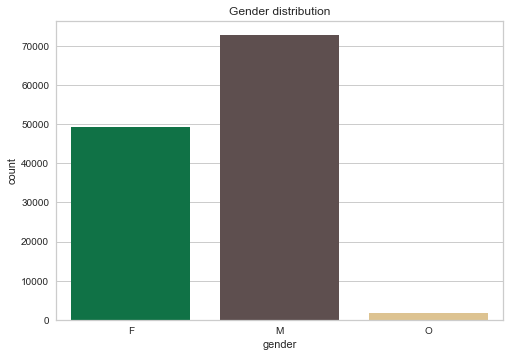

In [33]:
sns.set_palette(sns.color_palette(starbucks))

df = transactions[['gender', 'age', 'amount', 'income']]

ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender distribution');

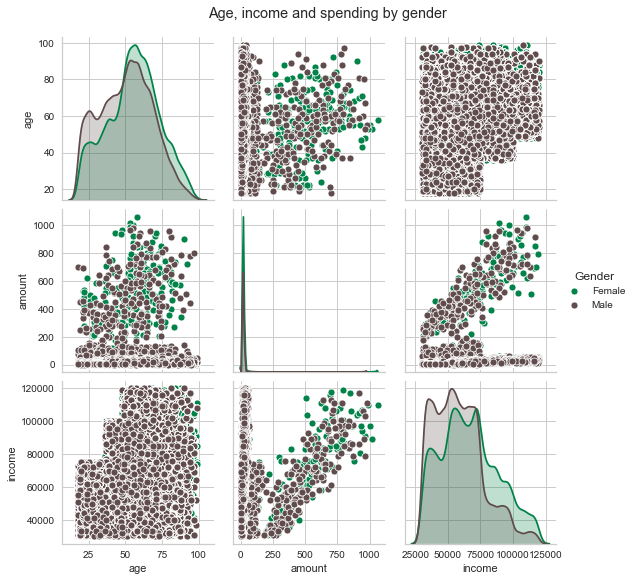

In [34]:
sns.set_palette(sns.color_palette(starbucks))

df = transactions[['gender', 'age', 'amount', 'income']].query('gender in ["F", "M"]')

df.rename(columns={'gender': 'Gender'}, inplace=True)
df['Gender'] = df['Gender'].map({'M': 'Male', 'F': 'Female'})

g = sns.pairplot(df, hue='Gender')
g.fig.suptitle("Age, income and spending by gender", y=1.05);

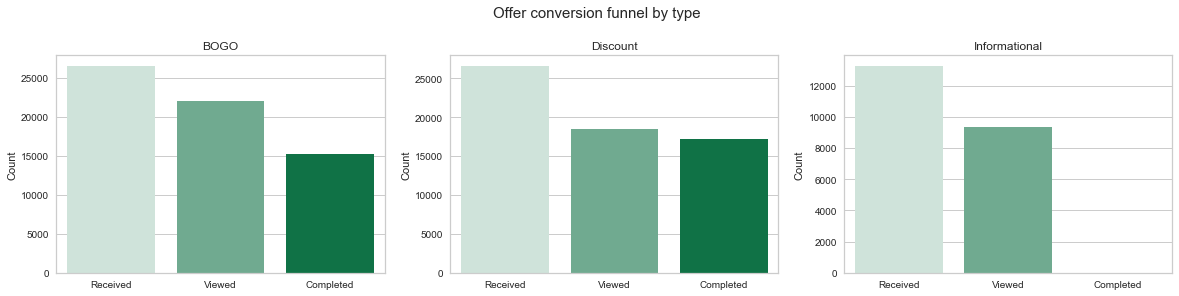

In [35]:
sns.set_palette(sns.color_palette(starbucks))

df = offers.groupby(['event', 'offer_type'])['person'].count().reset_index()
df['event'] = pd.Categorical(df['event'], ["offer received", "offer viewed", "offer completed"])
df.sort_values('event', inplace=True)

fig, axs = plt.subplots(ncols=3, figsize=(20, 4))

df['event'] = df['event'].map({'offer received': 'Received', 'offer viewed': 'Viewed', 'offer completed': 'Completed'})

ax = sns.barplot('event', y='person', data=df.query('offer_type == "bogo"'), palette=starbucks_d, ci=None, ax=axs[0])
ax.set(xlabel='', ylabel='Count', title='BOGO')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "discount"'), palette=starbucks_d, ci=None, ax=axs[1])
ax.set(xlabel='', ylabel='Count', title='Discount')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "informational"'), palette=starbucks_d, ci=None, ax=axs[2])
ax.set(xlabel='', ylabel='Count', title='Informational')

fig.suptitle('Offer conversion funnel by type', size=15, y=1.05);

In [36]:
#Creating 'age_range' column based on 'age'
age_range_labels = ['11-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
age_range_bins = [11, 20, 30, 40, 50, 60, 70, 80, 110]
profile['age_range'] = pd.cut(profile['age'], bins = age_range_bins, labels = age_range_labels, right = False)

#Adding a specific order to the age_range_field
profile['age_range'] = pd.Categorical(profile['age_range'], ordered = True, categories = age_range_labels)

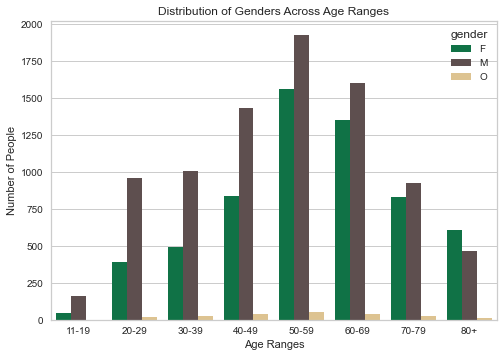

In [37]:
#Visualizing the gender distribution in a seaborn count plot
sns.countplot(data = profile, x = 'age_range', hue = 'gender');
plt.title('Distribution of Genders Across Age Ranges');
plt.xlabel('Age Ranges');
plt.ylabel('Number of People');
plt.style.use('seaborn');

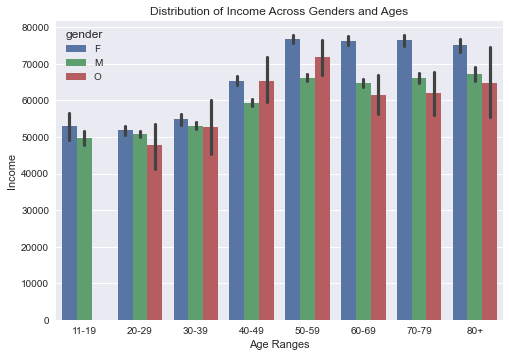

In [38]:
#Visualizing the gender/income/age range distribution in a seaborn bar plot
sns.barplot(data = profile, x = 'age_range', y = 'income', hue = 'gender');
plt.title('Distribution of Income Across Genders and Ages');
plt.xlabel('Age Ranges');
plt.ylabel('Income');
plt.style.use('seaborn');